In [ ]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import wordcloud 
from wordcloud import WordCloud
import statistics
from collections import Counter
import datetime
import textblob
from textblob import TextBlob
import sklearn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'FYP', 'report', 'd1 tml')
HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'Project')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
fake = pd.read_csv('/content/gdrive/My Drive/FYP/report/d1 tml/Project/FAKE.csv')
true = pd.read_csv('/content/gdrive/My Drive/FYP/report/d1 tml/Project/REAL.csv')

In [ ]:
fake

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
3,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
4,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
...,...,...,...,...
3159,6143,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,FAKE
3160,9337,Radio Derb Is On The Air–Leonardo And Brazil’s...,,FAKE
3161,8737,Assange claims ‘crazed’ Clinton campaign tried...,Julian Assange has claimed the Hillary Clinton...,FAKE
3162,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE


In [ ]:
true

,id,title,text,label
0,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
1,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
2,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
3,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
4,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL
...,...,...,...,...
3166,2316,Alabama Lawmaker: Same-Sex Couples Don’t Deser...,Most conservatives who oppose marriage equalit...,REAL
3167,3262,GOP Senator David Perdue Jokes About Praying f...,The freshman senator from Georgia quoted scrip...,REAL
3168,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
3169,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [ ]:
#Create column with labels
fake["label"] = "fake"
true["label"] = "true"

In [ ]:
#Check shapes of dataframes. I scraped 1844 articles to add to this dataset.
print (fake.shape)
print (true.shape)

(3164, 4)
(3171, 4)


In [ ]:
#True news has location and publisher, which fake doesn't have. Remove for consistency
true["text"] = true['text'].apply(lambda x: x.partition("-")[2])

In [ ]:
fake.drop("id", axis=1, inplace=True)
true.drop("id", axis=1, inplace=True)

In [ ]:
#Remove articles with only pictures / no text
true = true[true["text"] != ""] 
fake = fake[fake["text"] != ""]

In [ ]:
#The datasets are pretty balanced, which is good!
print(fake.shape)
print(true.shape)

(3164, 3)
(2902, 3)


In [ ]:
import ipywidgets as widgets
from IPython import display
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(fake.head(5))
with widget2:
    display.display(true.head(5))

# create HBox
hbox = widgets.HBox([widget1, widget2])

# render hbox
hbox

In [ ]:
fake.to_csv('fakeForModeling.csv')
!cp fakeForModeling.csv "/content/gdrive/My Drive/FYP/report/d1 tml/Project"

In [ ]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3164 entries, 0 to 3163
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   3164 non-null   object
 1   text    3164 non-null   object
 2   label   3164 non-null   object
dtypes: object(3)
memory usage: 98.9+ KB


In [ ]:
true.to_csv('trueForModeling.csv')
!cp trueForModeling.csv "/content/gdrive/My Drive/FYP/report/d1 tml/Project"

In [ ]:
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
  
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english', 'arabic'))
stop_words.extend(["said", "reuters", "CNN", "would", "image", "via"]) #extend stopwords to include these words too

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()  

words_in_t = [] #all tokens in true articles
words_in_f = [] #all tokens in fake articles
words_in_each_article_t = [] #list of true articles, each in tokenized form
words_in_each_article_f = [] #list of fake articles, each in tokenized form

def process(df, word_list, by_article_list):
  for article in (df["text"]):
    words = word_tokenize(article)
    words = [word.lower() for word in words if word.isalpha()] #lowercase
    words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
    words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form

    by_article_list.append(words)
    for w in words:
      word_list.append(w)

In [ ]:
#NOTE: If rerunning, this cell will take a while
process(fake, words_in_f, words_in_each_article_f)

In [ ]:
#NOTE: If rerunning, this cell will take a while
process(true, words_in_t, words_in_each_article_t)

In [ ]:
from collections import Counter

bigrams_true = zip(words_in_t, words_in_t[1:])
bigram_counts_true = Counter(bigrams_true)
bigrams_true = pd.DataFrame(bigram_counts_true.most_common(20), columns=["Bigram", "Count"])
bigrams_true

,Bigram,Count
0,"(united, state)",1356
1,"(white, house)",1328
2,"(donald, trump)",1311
3,"(new, york)",1285
4,"(hillary, clinton)",1278
5,"(fox, news)",918
6,"(new, hampshire)",805
7,"(president, obama)",715
8,"(islamic, state)",686
9,"(secretary, state)",635


In [ ]:
bigrams_false = zip(words_in_f, words_in_f[1:])
bigram_counts_false = Counter(bigrams_false)
bigrams_false = pd.DataFrame(bigram_counts_false.most_common(20), columns=["Bigram", "Count"])
bigrams_false

,Bigram,Count
0,"(hillary, clinton)",2454
1,"(donald, trump)",1735
2,"(united, state)",1405
3,"(white, house)",727
4,"(new, york)",677
5,"(clinton, campaign)",503
6,"(clinton, foundation)",433
7,"(secretary, state)",404
8,"(wall, street)",378
9,"(bill, clinton)",365


In [ ]:
trigrams_true = zip(words_in_t, words_in_t[1:], words_in_t[2:])
trigram_counts_true = Counter(trigrams_true)
trigrams_true = pd.DataFrame(trigram_counts_true.most_common(20), columns=["Trigram", "Count"])
trigrams_true

,Trigram,Count
0,"(new, york, time)",274
1,"(president, barack, obama)",226
2,"(former, secretary, state)",170
3,"(told, fox, news)",166
4,"(associated, press, contributed)",165
5,"(press, contributed, report)",164
6,"(president, united, state)",134
7,"(gov, john, kasich)",133
8,"(affordable, care, act)",132
9,"(new, york, city)",131


In [ ]:
trigrams_false = zip(words_in_f, words_in_f[1:], words_in_f[2:])
trigram_counts_false = Counter(trigrams_false)
trigrams_false = pd.DataFrame(trigram_counts_false.most_common(20), columns=["Trigram", "Count"])
trigrams_false

,Trigram,Count
0,"(new, york, time)",259
1,"(director, james, comey)",164
2,"(fbi, director, james)",153
3,"(president, united, state)",104
4,"(dakota, access, pipeline)",97
5,"(hillary, clinton, email)",96
6,"(hillary, clinton, campaign)",90
7,"(investigation, hillary, clinton)",83
8,"(wall, street, journal)",83
9,"(private, email, server)",80


In [ ]:
wordcounts_t = Counter(words_in_t)
wordcounts_f = Counter(words_in_f)

In [ ]:
mostcommon_t = Counter(wordcounts_t).most_common(20)
mostcommon_f = Counter(wordcounts_f).most_common(20)

t_plot = dict(mostcommon_t)
mostcommon_t = pd.DataFrame(mostcommon_t, columns = ["Word", "Count"])
mostcommon_t = mostcommon_t.reset_index(drop=True)
mostcommon_t = mostcommon_t['Word'].tolist()

f_plot = dict(mostcommon_f)
mostcommon_f = pd.DataFrame(mostcommon_f, columns = ["Word", "Count"])
mostcommon_f = mostcommon_f.reset_index(drop=True)
mostcommon_f = mostcommon_f['Word'].tolist()

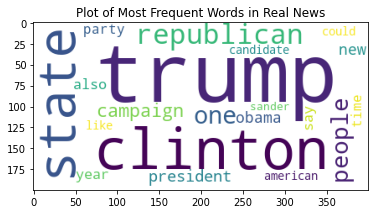

In [ ]:
t_wc = WordCloud(max_words=25,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(t_plot)

plt.imshow(t_wc)
plt.title("Plot of Most Frequent Words in Real News")
plt.show()

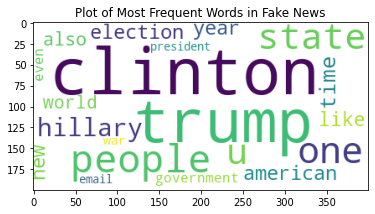

In [ ]:
f_wc = WordCloud(max_words=25,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(f_plot)

plt.imshow(f_wc)
plt.title("Plot of Most Frequent Words in Fake News")
plt.show()

In [ ]:
#Of the top 20 words in each class, 9 words are common 
len(set(mostcommon_t) & set(mostcommon_f))

12

In [ ]:
#Get tokenized forms of all articles (true and fake) in one dataframe
X = []
for a in words_in_each_article_t:
  X.append(a)
for b in words_in_each_article_f:
  X.append(b)

In [ ]:
#Get labels of all articles (true and fake) in one dataframe
y = pd.concat([true["label"], fake["label"]])
y = [1 if x == "fake" else 0 for x in y] #1 and 0 for ease of tokenizing

In [ ]:
articles = pd.DataFrame(X)
y = pd.DataFrame(y, columns=["label"])

In [ ]:
articles.to_csv('articles.csv')
!cp articles.csv "/content/gdrive/My Drive/FYP/report/d1 tml/Project"

y.to_csv('labels.csv')
!cp labels.csv "/content/gdrive/My Drive/FYP/report/d1 tml/Project"

In [ ]:
import sklearn.model_selection as ms

#Create 80-20 train test split
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.2, random_state=1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Keep words that appear in greater than 10% of documents. Override preprocessor and implement on list of words
#in each article in order to keep the words we have cleaned for earlier
tfidf = TfidfVectorizer(min_df = 0.1, preprocessor = ' '.join)

#Implement on train dataset
response_train = tfidf.fit_transform(X_train) #This is the Sparse Document-Term Matrix
feature_names_train = tfidf.get_feature_names()
dense_train = response_train.todense() #This is the Dense Document-Term Matrix
denselist_train = dense_train.tolist()

In [ ]:
df_train = pd.DataFrame(denselist_train, columns=feature_names_train)
df_train

,able,according,across,act,action,actually,added,administration,ago,almost,along,already,also,although,always,america,american,among,announced,another,answer,anyone,anything,area,around,article,asked,attack,authority,away,back,bad,based,become,began,behind,belief,believe,best,better,...,two,understand,united,university,use,used,using,victory,video,view,vote,voter,voting,wall,want,wanted,war,washington,way,wednesday,week,well,went,whether,white,whole,whose,win,within,without,woman,word,work,working,world,wrote,year,yet,york,young
0,0.0,0.000000,0.07269,0.000000,0.000000,0.069503,0.000000,0.000000,0.070675,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.240058,0.048923,0.000000,0.000000,0.000000,0.0,0.0,0.074806,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.053126,0.0,0.0,0.000000,0.000000,0.0,0.0,0.065841,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.063483,0.0,0.0,0.000000,0.0,0.128522,0.000000,0.098614,0.000000,0.0,0.000000,0.0,0.062370,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.116428,0.0,0.113030,0.000000,0.042942,0.000000,0.000000,0.0
1,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.078185,0.000000,0.0000,0.0,0.207553,0.000000,0.0,0.0,0.063719,0.000000,0.000000,0.087971,0.060211,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.140626,0.087918,0.0,0.000000,0.0,0.0,0.000000,0.085080,0.0,0.0,0.069905,0.0,0.000000,...,0.0,0.000000,0.000000,0.083207,0.068050,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.477592,0.066961,0.000000,0.085222,0.0,0.000000,0.0,0.000000,0.062913,0.0,0.085365,0.0,0.080045,0.00000,0.000000,0.0,0.000000,0.0,0.060003,0.000000,0.000000,0.069689,0.074488,0.0
2,0.0,0.000000,0.00000,0.000000,0.136104,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.282768,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.127590,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.123484,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.148110,0.000000,0.000000,0.000000,0.0
3,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.170603,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.190767,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.151883,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.332786,0.0,0.000000,0.0,0.000000,0.00000,0.184599,0.0,0.000000,0.0,0.317395,0.000000,0.000000,0.000000,0.000000,0.0
4,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.056231,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.228736,0.0,0.000000,0.0,0.0,0.000000,0.110675,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.111046,0.0,0.000000,0.00000,0.000000,0.0,0.080402,0.0,0.000000,0.000000,0.118618,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4847,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.056649,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.147839,0.0,0.0,0.0

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor = ' '.join, vocabulary = feature_names_train)

#Implement on test dataset
response_test = tfidf.fit_transform(X_test) #This is the Sparse Document-Term Matrix
feature_names_test = tfidf.get_feature_names()
dense_test = response_test.todense() #This is the Dense Document-Term Matrix
denselist_test = dense_test.tolist()

In [ ]:
df_test = pd.DataFrame(denselist_test, columns=feature_names_test)
df_test

,able,according,across,act,action,actually,added,administration,ago,almost,along,already,also,although,always,america,american,among,announced,another,answer,anyone,anything,area,around,article,asked,attack,authority,away,back,bad,based,become,began,behind,belief,believe,best,better,...,two,understand,united,university,use,used,using,victory,video,view,vote,voter,voting,wall,want,wanted,war,washington,way,wednesday,week,well,went,whether,white,whole,whose,win,within,without,woman,word,work,working,world,wrote,year,yet,york,young
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.104104,0.00000,0.00000,0.108190,0.000000,0.056404,0.000000,0.000000,0.000000,0.000000,0.091362,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.089895,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.069906,0.000000,0.085821,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221763,0.000000,0.086528,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.082263,0.0,0.081530,0.0,0.178143,0.0,0.000000,0.0
1,0.000000,0.000000,0.021023,0.0,0.021477,0.000000,0.00000,0.043431,0.00000,0.02192,0.000000,0.000000,0.094125,0.000000,0.022613,0.292830,0.101526,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.018752,0.0,0.0,0.019617,0.025180,0.040244,0.031579,0.047683,0.000000,0.000000,0.000000,0.000000,0.0,0.059786,0.0,0.097478,...,0.000000,0.000000,0.035803,0.000000,0.019288,0.0,0.000000,0.000000,0.000000,0.021878,0.018074,0.000000,0.024281,0.000000,0.047702,0.0,0.057003,0.000000,0.044857,0.000000,0.000000,0.030964,0.000000,0.000000,0.000000,0.0,0.024058,0.000000,0.000000,0.0,0.000000,0.021715,0.068639,0.0,0.102040,0.0,0.012387,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.123065,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.261377,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.05181,0.000000,0.05024,0.00000,0.053743,0.000000,0.028019,0.000000,0.000000,0.087168,0.034539,0.045384,0.0,0.040397,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.047919,0.000000,0.000000,0.000000,0.048959,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.034725,0.000000,0.000000,0.052598,0.045932,0.0,0.000000,0.171876,0.000000,0.104203,0.043042,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.044917,0.213646,0.000000,0.000000,0.036869,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.054399,0.0,0.000000,0.000000,0.000000,0.0,0.080999,0.0,0.088492,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.0,0.000000,0.064963,0.00000,0.387601,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.116714,0.074908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.066474,0.000000,0.066605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.049584,0.000000,0.000000,0.057466,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
#This is the final data to be used for training models
df_train.to_csv('training_data.csv')
!cp training_data.csv "/content/gdrive/My Drive/FYP/report/d1 tml/Project"

In [ ]:
#This is the final data to be used for testing models
df_test.to_csv('testing_data.csv')
!cp testing_data.csv "/content/gdrive/My Drive/FYP/report/d1 tml/Project"

In [ ]:
y_train = pd.DataFrame(y_train, columns=["label"])
y_test = pd.DataFrame(y_test, columns=["label"])

In [ ]:
#Final labels to be used for training models
y_train.to_csv('train_labels.csv')
!cp train_labels.csv "/content/gdrive/My Drive/FYP/report/d1 tml/Project"

In [ ]:
#Final labels to be used for testing models
y_test.to_csv('test_labels.csv')
!cp test_labels.csv "/content/gdrive/My Drive/FYP/report/d1 tml/Project"

From medium Getting Real with Fake news